<a href="https://colab.research.google.com/github/AquaSense-Capstone/Baseline_Model-ML/blob/main/Capstone%20Project/flood_risk_prediction/forecast_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/AquaSense-Capstone/Baseline_Model-ML/raw/main/Capstone%20Project/Model_v2/Dataset/Tinggi_Air.csv
!wget https://github.com/AquaSense-Capstone/Baseline_Model-ML/raw/main/Capstone%20Project/Model_v2/Dataset/laporan_iklim_harian.csv

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import lite
import matplotlib.pyplot as plt

In [2]:
# Membaca dataset tinggi_air
df_tinggi_air = pd.read_csv('Tinggi_Air.csv', parse_dates=['tanggal'])

# Membaca dataset laporan_iklim_harian
df_laporan_iklim = pd.read_csv('laporan_iklim_harian.csv', parse_dates=['Tanggal'], dayfirst=True)

# Mengganti tanda koma dengan titik pada kolom 'curah_hujan'
df_laporan_iklim['curah_hujan'] = df_laporan_iklim['curah_hujan'].str.replace(',', '.')
# Mengonversi kolom 'curah_hujan' ke tipe data float
df_laporan_iklim['curah_hujan'] = pd.to_numeric(df_laporan_iklim['curah_hujan'], errors='coerce')

# Menggabungkan dataframe berdasarkan tanggal
result_df = pd.merge(df_tinggi_air, df_laporan_iklim, left_on=df_tinggi_air['tanggal'].dt.date, right_on=df_laporan_iklim['Tanggal'].dt.date, how='left')

dataset = result_df[['nama_pintu_air', 'lokasi', 'tinggi_normal' , 'tinggi_siaga_3' , 'tinggi_siaga_2' ,'tanggal', 'tinggi_air', 'curah_hujan', 'status_siaga']]
# Menampilkan hasil
print(dataset)

             nama_pintu_air              lokasi  tinggi_normal  \
0            PS. Angke Hulu               Angke           1490   
1            PS. Angke Hulu               Angke           1490   
2            PS. Angke Hulu               Angke           1490   
3      PS. Katulampa (Hulu)            Ciliwung            790   
4                 PS. Depok            Ciliwung           1990   
...                     ...                 ...            ...   
13303         PA. Manggarai            Ciliwung           7490   
13304            P.A. Karet  Banjir Kanal Barat           4490   
13305        PS. Angke Hulu               Angke           1490   
13306   P.A. Jembatan Merah            Ciliwung           1490   
13307    P.A. Ancol Flusing            Ciliwung           1790   

       tinggi_siaga_3  tinggi_siaga_2             tanggal  tinggi_air  \
0                2490            2990 2019-12-31 23:00:00         900   
1                2490            2990 2019-12-31 23:00:00    

In [3]:
# Menghitung jumlah baris dengan nilai NaN dalam DataFrame
jumlah_nan = dataset.isna().sum()

print("Jumlah NaN untuk setiap kolom:")
print(jumlah_nan)

Jumlah NaN untuk setiap kolom:
nama_pintu_air       0
lokasi               0
tinggi_normal        0
tinggi_siaga_3       0
tinggi_siaga_2       0
tanggal              0
tinggi_air           0
curah_hujan       2280
status_siaga         0
dtype: int64


In [4]:
dataset = pd.DataFrame(dataset)
# Mengganti nilai '8888' dan '9999' dengan NaN
dataset['curah_hujan']=dataset['curah_hujan'].replace([8888, 9999], pd.NA)

# Menghapus baris yang masih memiliki NaN
dataset.dropna(inplace=True)

# # Menghapus duplikat data
dataset = dataset.drop_duplicates()

jumlah_nan = dataset.isna().sum()
print("Jumlah NaN untuk setiap kolom:")
print(jumlah_nan)

Jumlah NaN untuk setiap kolom:
nama_pintu_air    0
lokasi            0
tinggi_normal     0
tinggi_siaga_3    0
tinggi_siaga_2    0
tanggal           0
tinggi_air        0
curah_hujan       0
status_siaga      0
dtype: int64


In [5]:
dataset

,nama_pintu_air,lokasi,tinggi_normal,tinggi_siaga_3,tinggi_siaga_2,tanggal,tinggi_air,curah_hujan,status_siaga
0,PS. Angke Hulu,Angke,1490,2490,2990,2019-12-31 23:00:00,900,0.0,Normal
3,PS. Katulampa (Hulu),Ciliwung,790,1490,1990,2019-12-31 23:40:00,480,0.0,Normal
4,PS. Depok,Ciliwung,1990,2690,3490,2019-12-31 23:40:00,1720,0.0,Normal
5,PA. Manggarai,Ciliwung,7490,8490,9490,2019-12-31 23:40:00,6320,0.0,Normal
6,P.A. Karet,Banjir Kanal Barat,4490,5490,5990,2019-12-31 23:40:00,3290,0.0,Normal
...,...,...,...,...,...,...,...,...,...
12880,P.A. Karet,Banjir Kanal Barat,4490,5490,5990,2020-01-30 23:40:00,2710,22.0,Normal
12881,PS. Angke Hulu,Angke,1490,2490,2990,2020-01-30 23:40:00,850,22.0,Normal
12882,P.A. Istiqlal,Ciliwung,2490,2990,3490,2020-01-30 23:40:00,2250,22.0,Normal
12883,P.A. Jembatan Merah,Ciliwung,1490,1990,2490,2020-01-30 23:40:00,1760,22.0,Siaga 2


In [6]:
df = dataset[dataset['nama_pintu_air'] == 'P.A. Jembatan Merah']
df = df[['tanggal', 'curah_hujan', 'tinggi_air']]
df

,tanggal,curah_hujan,tinggi_air
8,2019-12-31 23:40:00,0.0,1600
10,2020-01-01 00:00:00,145.3,1640
22,2020-01-01 00:40:00,145.3,1700
33,2020-01-01 01:10:00,145.3,1750
41,2020-01-01 01:40:00,145.3,1800
...,...,...,...
12847,2020-01-30 21:40:00,22.0,1760
12855,2020-01-30 22:10:00,22.0,1770
12864,2020-01-30 22:40:00,22.0,1760
12874,2020-01-30 23:10:00,22.0,1760


In [ ]:
# Mengonversi kolom tanggal menjadi timestemp
df['tanggal'] = pd.to_datetime(df['tanggal'])

# Menjadikan kolom tanggal sebagai indeks
df.set_index('tanggal', inplace=True)

# Memilih fitur dan target
X = df[['curah_hujan']].values
y = df['tinggi_air'].values

# Normalisasi data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Mengubah data menjadi format time series
def create_time_series_data(X, y, time_steps=1):
    X_time_series, y_time_series = [], []
    for i in range(len(X) - time_steps):
        X_time_series.append(X[i:(i + time_steps)])
        y_time_series.append(y[i + time_steps])
    return np.array(X_time_series), np.array(y_time_series)

time_steps = 10  # Sesuaikan dengan jumlah time steps yang diinginkan
X_time_series, y_time_series = create_time_series_data(X_normalized, y, time_steps)

# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_time_series, y_time_series, test_size=0.2, random_state=42)

In [30]:
# Membuat model menggunakan TensorFlow dengan LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(units=50, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(units=50, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Menyusun model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
model.fit(X_train, y_train, epochs=500, batch_size=5, verbose=2)

# Memprediksi tinggi air pada data pengujian
y_pred = model.predict(X_test)

# Mengembalikan data ke skala aslinya
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler.inverse_transform(y_pred).flatten()

# Menghitung evaluasi kinerja model
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)

# Menampilkan hasil evaluasi
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Epoch 1/500
174/174 - 11s - loss: 1102678.5000 - 11s/epoch - 63ms/step
Epoch 2/500
174/174 - 3s - loss: 50012.0000 - 3s/epoch - 15ms/step
Epoch 3/500
174/174 - 2s - loss: 53262.8438 - 2s/epoch - 13ms/step
Epoch 4/500
174/174 - 2s - loss: 54174.8359 - 2s/epoch - 12ms/step
Epoch 5/500
174/174 - 2s - loss: 52334.4102 - 2s/epoch - 14ms/step
Epoch 6/500
174/174 - 2s - loss: 56450.0547 - 2s/epoch - 13ms/step
Epoch 7/500
174/174 - 2s - loss: 51241.8047 - 2s/epoch - 13ms/step
Epoch 8/500
174/174 - 3s - loss: 54130.7930 - 3s/epoch - 15ms/step
Epoch 9/500
174/174 - 2s - loss: 59602.3789 - 2s/epoch - 12ms/step
Epoch 10/500
174/174 - 2s - loss: 54921.5742 - 2s/epoch - 13ms/step
Epoch 11/500
174/174 - 2s - loss: 55102.2266 - 2s/epoch - 12ms/step
Epoch 12/500
174/174 - 3s - loss: 55260.5352 - 3s/epoch - 15ms/step
Epoch 13/500
174/174 - 3s - loss: 50432.2031 - 3s/epoch - 17ms/step
Epoch 14/500
174/174 - 2s - loss: 53972.2773 - 2s/epoch - 12ms/step
Epoch 15/500
174/174 - 2s - loss: 54286.1328 - 2s/epo

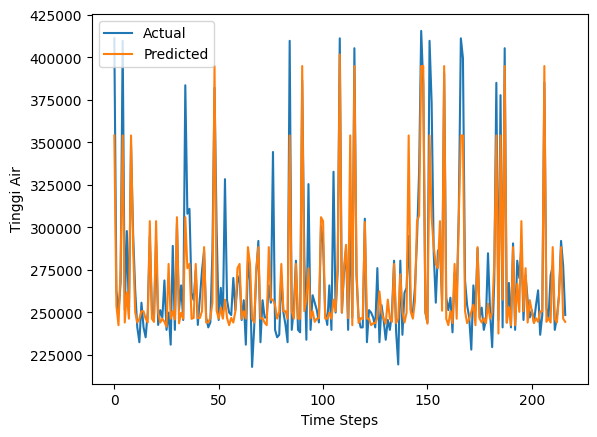

In [31]:
# Visualisasi hasil prediksi
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Tinggi Air')
plt.legend()
plt.show()

In [32]:
# Simpan model Keras ke dalam file
model.save('model_aquasense.h5')

# Muat model Keras dari file
loaded_model = tf.keras.models.load_model('model_aquasense.h5')

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
converter = lite.TFLiteConverter.from_keras_model(loaded_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('model_aquasense.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ThinkPad\AppData\Local\Temp\tmp7udz2_70\assets


INFO:tensorflow:Assets written to: C:\Users\ThinkPad\AppData\Local\Temp\tmp7udz2_70\assets


79568